In [42]:
import reactord as rd
import reactord.flowreactors.stationary_1d.pfr as pfr

import numpy as np

import matplotlib.pyplot as plt

### Definicion de las substancias

In [43]:
a = rd.Substance.from_thermo_database(name="methane", thermo_identification="methane")
b = rd.Substance.from_thermo_database(name="ethane", thermo_identification="ethane")

### Definicion de la mezcla

In [47]:
mix = rd.mix.IdealSolution([a, b])

### Definicion de kinetics

In [58]:
def ra(concentrations, temperature):
    ra = 0.0005 * concentrations[0]
    return ra

stoichiometry = np.array([-2, 1])

kinetic = rd.Kinetics(mix, [ra], stoichiometry)

### Definicion de balances

In [51]:
mb = pfr.mass_balances.df_dz(
    molar_flows_in={"methane": 0.001, "ethane": 0},
    molar_flows_out={}
)

eb = pfr.energy_balances.Isothermic(400)

pb = pfr.pressure_balances.Isobaric(101325)

### Definicion del reactor

In [52]:
reactor = pfr.PFR(
    mix = mix,
    kinetics = kinetic,
    reactor_length = 0.001,
    transversal_area = 1,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb
)

### El repr() del reactor te devuelve el latex de los balances

In [53]:
reactor

\frac{1}{a_t}\frac{dF_i}{dz}=r_i
\frac{dT}{dz}=0
\frac{dT_r}{dz}=0
\frac{dP}{dz}=0

### El irepr del reactor te renderiza los latex si estas en un entorno interactivo

In [54]:
reactor.irepr

Mass balance:


\frac{1}{a_t}\frac{dF_i}{dz}=r_i

Reactor and refrigerant energy balances:


\frac{dT}{dz}=0

\frac{dT_r}{dz}=0

Pressure balance:


\frac{dP}{dz}=0

### Simulamos el reactor

In [56]:
reactor.simulate(tol = 0.001, max_nodes = 1000, verbose = 1)

Solved in 2 iterations, number of nodes 203. 
Maximum relative residual: 6.21e-06 
Maximum boundary residual: 0.00e+00


In [60]:
reactor.sim_df

,z,methane,ethane,temperature,refrigerant_temperature,pressure
0,0.000000,1.000000e-03,0.000000,400.0,0.0,101325.0
1,0.000010,9.019503e-04,0.000049,400.0,0.0,101325.0
2,0.000020,8.113493e-04,0.000094,400.0,0.0,101325.0
3,0.000030,7.279666e-04,0.000136,400.0,0.0,101325.0
4,0.000040,6.515317e-04,0.000174,400.0,0.0,101325.0
...,...,...,...,...,...,...
198,0.000987,1.918504e-09,0.000500,400.0,0.0,101325.0
199,0.000990,1.828592e-09,0.000500,400.0,0.0,101325.0
200,0.000993,1.742577e-09,0.000500,400.0,0.0,101325.0
201,0.000997,1.660206e-09,0.000500,400.0,0.0,101325.0


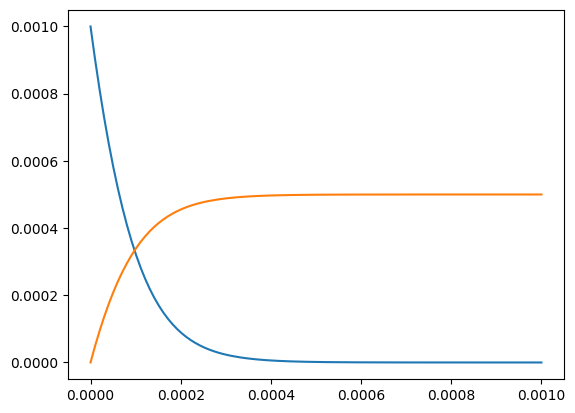

In [61]:
plt.plot(reactor.sim_df["z"], reactor.sim_df["methane"])
plt.plot(reactor.sim_df["z"], reactor.sim_df["ethane"])

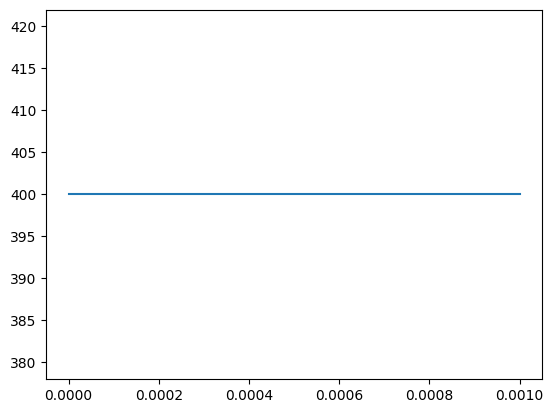

In [62]:
plt.plot(reactor.sim_df["z"], reactor.sim_df["temperature"])